In [1]:
from helpers import *
import numpy as np
import pandas as pd
from implementations import *
import matplotlib.pyplot as plt

In [2]:
data_path = '../data/dataset_to_release'
x_train_preclean, x_test_preclean, y_train, train_ids, test_ids = load_csv_data(data_path)

In [3]:
def unique_values(x_col):
    return len(np.unique(x_col))

unique_values = np.apply_along_axis(unique_values, 0, x_train_preclean)


In [4]:
print(unique_values)

[    53     12    414     12     31      2      2  21780  21780      2
      3      2      2      3      3     17     13     12      2      2
      3      3      2      3      5     26      8     34     33     34
      4      5      5      8      7      5      4      7      5      4
      4      5      5      4      4      5      4      4      7     99
      2      7      7      5      5      9      5      5      9     26
     11      5    551    143      5      5      5      5      5      5
      5      5      5      6      5     11      6     41     49     44
     59    110    135    109    116    104    134      5     78    116
    195     79    100    169    102      5      5      6     14      9
      5     29     14      5      5    413     12      5      6      4
     80     73     48     42     46      8      5      5      6     18
      8      7     16      5      5      9      5      9      8      8
     11      9      5      5      4      4      5      8      8      8
      

(array([ 73., 139.,  17.,  12.,   0.,   4.,   6.,   1.,   3.,   3.,   2.,
          1.,   1.,   0.,   2.,   2.,   1.,   0.,   3.,   6.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

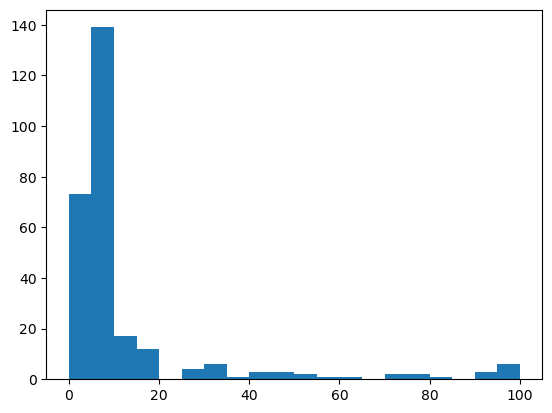

In [5]:
plt.hist(unique_values, bins=20, range=[0,100])


In [51]:
## get a smaller subset of the data 
## find out the indicies of columes where the unique values are less than 5? 

cate_indices = np.argwhere(unique_values < 5 ).flatten()
print(cate_indices)
print(cate_indices.shape)

[  5   6   9  10  11  12  13  14  18  19  20  21  22  23  30  36  39  40
  43  44  46  47  50 109 134 135 146 160 200 217 223 227 230 231 232 233
 234 235 236 237 238 241 243 247 255 260 261 263 265 272 274 275 278 279
 280 281 282 283 284 289 290 298 306 307 308 309 310 312 316 317 318 319
 320]
(73,)


In [52]:
smaller_x_train = x_train_preclean[:, cate_indices]

In [55]:
## now let's do the one hot encoding
def process_categorical(one_col):
    """ 
    why do I need this: some categorical data has this format (1, 2, 7, 9), but encoding needs it to be (0, 1, 2, 3) continuous discrete numbers 
    """
    unique_values = np.sort(np.unique(one_col))
    return_col = -1 * np.ones(one_col.shape)
    for i in range(len(unique_values)):
        return_col[one_col == unique_values[i]] = i 
    return return_col.astype(int)


def one_hot_encoding(one_col):
    b = np.zeros((one_col.size, len(np.unique(one_col))))
    b[np.arange(one_col.size), one_col] = 1
    
    return b

def one_hot_encoding_interpretability(x_train, cate_indices, num_indices):
    """
    Attempt to maintain the interpretability of the columns 
    Args:
        x_train is needed to get the unique values of the categorical columns, so we know what it's exploded to 
        cate_indices: the indices of the categorical columns, based on the original data 
        num_indices: the indices of the numerical columns, based on the original data
    """
    unique_values = np.unique(x_train[:, cate_indices], axis=0)
    

In [56]:
smaller_x_train = np.apply_along_axis(process_categorical, 0, smaller_x_train)

encoded_x_train = np.empty((len(smaller_x_train), 0))
for i in range(smaller_x_train.shape[1]):
    encoded_x_train = np.append(encoded_x_train, one_hot_encoding(smaller_x_train[:,i]), axis=1)

encoded_x_train.shape

(328135, 233)

In [48]:
print(encoded_x_train)

[[1. 0. 1. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 0.]]


In [49]:
## checking my process cateogrical function
test = np.array([[2, 2, 3],[1, 3, 4], [2, 5, 9]])
print(test)
test_process = np.apply_along_axis(process_categorical, 0, test)
print(test_process)
one_col_temp = one_hot_encoding(test_process[:, 0])
print(one_col_temp)
print("shape", one_col_temp.shape)

[[2 2 3]
 [1 3 4]
 [2 5 9]]
[[1 0 0]
 [0 1 1]
 [1 2 2]]
[[0. 1.]
 [1. 0.]
 [0. 1.]]
shape (3, 2)


In [70]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.

    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold

    >>> build_k_indices(np.array([1., 2., 3., 4.]), 2, 1)
    array([[3, 2],
           [0, 1]])
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [ ]:
## Writing the cross validation function on regularized logsitic regression
def cross_validation(y, x, k_fold, lambda_):
    """
    Separate the training set into k_fold parts, get k_fold sets of w weights, and return the average w 
    Args: 
        y, 
        x, 
        k_fold,
        lambda_,
    
    Return:
        average weight
        losses (loss of each fold)
    """
    k_indices = build_k_indices(y, k_fold, 1)
    losses = []
    weights = []
    for k in range(k_fold):
        test_indices = k_indices[k]
        train_indices = k_indices[~(np.arange(k_indices.shape[0]) == k)].flatten()
        x_train = x[train_indices]
        y_train = y[train_indices]
        x_test = x[test_indices]
        y_test = y[test_indices]
        
        w, loss = reg_logistic_regression(y_train, x_train, lambda_, np.zeros(x_train.shape[1]), 100, 0.1)
        losses.append(loss)
        weights.append(w)
    
    return np.mean(weights, axis=0), losses
